# How to build an AI that can answer questions about your website

- https://platform.openai.com/docs/tutorials/web-qa-embeddings
- https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb
- https://github.com/openai/openai-cookbook/blob/main/LICENSE
- https://github.com/openai/tiktoken

# Fetch pages

In [53]:
import wikipediaapi

wiki = wikipediaapi.Wikipedia(
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI
)


In [54]:
page_names = [
    "Titanic (1997 film)",
    "Dilwale Dulhania Le Jayenge",
    "Kung Fu Hustle",
    "Dil Chahta Hai",
    "The Matrix",
    "Terminator 2: Judgment Day",
    "Swades",
    "Crows Zero",
]

In [55]:
pages = [wiki.page(page_name).text for page_name in page_names]

In [56]:
pages

['Titanic is a 1997 American epic romance and disaster film directed, written, produced, and co-edited by James Cameron. Incorporating both historical and fictionalized aspects, it is based on accounts of the sinking of the RMS Titanic and stars Kate Winslet and Leonardo DiCaprio as members of different social classes who fall in love aboard the ship during its ill-fated maiden voyage. The film also features Billy Zane, Kathy Bates, Frances Fisher, Gloria Stuart, Bernard Hill, Jonathan Hyde, Victor Garber, and Bill Paxton.\nCameron\'s inspiration for the film came from his fascination with shipwrecks; he felt a love story interspersed with the human loss would be essential to convey the emotional impact of the disaster. Production began on September 1, 1995, when Cameron shot footage of the actual Titanic wreck. The modern scenes on the research vessel were shot on board the Akademik Mstislav Keldysh, which Cameron had used as a base when filming the wreck. Scale models, computer-gener

# Build embeddings

In [57]:
import pandas as pd

df = pd.DataFrame(zip(page_names, pages), columns=['title', 'text'])

df.to_parquet('scraped.parquet', index=False)

In [58]:
df

,title,text
0,Titanic (1997 film),Titanic is a 1997 American epic romance and di...
1,Dilwale Dulhania Le Jayenge,"Dilwale Dulhania Le Jayenge (transl. ""The Big-..."
2,Kung Fu Hustle,Kung Fu Hustle (Chinese: 功夫; lit. 'Kung Fu') i...
3,Dil Chahta Hai,Dil Chahta Hai (transl. The Heart Desires) is ...
4,The Matrix,The Matrix is a 1999 science fiction action fi...
5,Terminator 2: Judgment Day,Terminator 2: Judgment Day is a 1991 American ...
6,Swades,"Swades: We, the People (transl. Homeland) is a..."
7,Crows Zero,"Crows Zero (クローズZERO, Kurōzu Zero), also known..."


In [59]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [60]:
# Set the text column to be the raw text with the newlines removed
df['text'] = df.title + ". " + remove_newlines(df.text)

<Axes: >

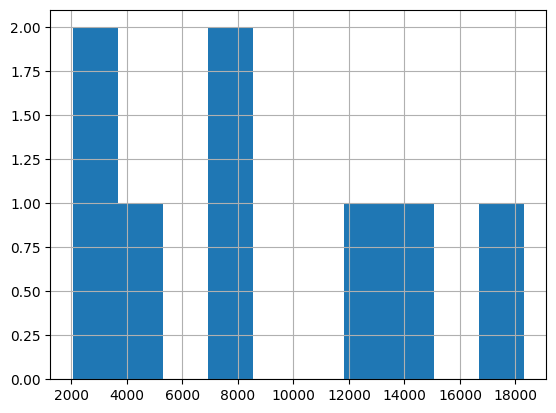

In [61]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [62]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

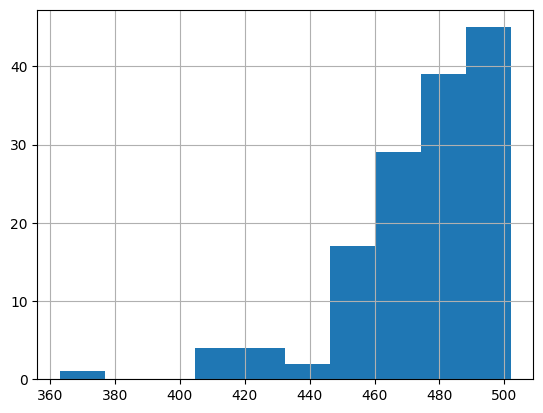

In [63]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [65]:
import time
import openai


def sleepy_embedding_create(x):
    time.sleep(1)  # Sleep for 1 second to avoid rate limiting
    return openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding']


df['embeddings'] = df.text.apply(sleepy_embedding_create)

df.to_parquet('embeddings.parquet', index=False)

df.head()

,text,n_tokens,embeddings
0,Titanic (1997 film). Titanic is a 1997 America...,481,"[-0.022004509344697, -0.04352512210607529, -0...."
1,A number of re-releases since 1997 have pushed...,496,"[-0.02198009565472603, -0.03273024037480354, 0..."
2,Jack is confined in the master-at-arms' office...,450,"[-0.012324808165431023, -0.02499849535524845, ..."
3,Cast Fictional characters Kate Winslet as Rose...,478,"[-0.017220471054315567, -0.025225453078746796,..."
4,"Jack is portrayed as an itinerant, poor orphan...",488,"[-0.014683247543871403, -0.029444804415106773,..."


In [66]:
from openai.embeddings_utils import distances_from_embeddings

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [67]:
def answer_question(
    df,
    model="text-davinci-003",
    question="What movies were made by Stephen Chow?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [68]:
answer_question(df, question="What are some movies made by Stephen Chow?", debug=True)

Context:
Kung Fu Hustle. Kung Fu Hustle (Chinese: 功夫; lit. 'Kung Fu') is a 2004 Cantonese-language action comedy film directed, produced, co-written by, and starring Stephen Chow. The film tells the story of a murderous neighbourhood gang, a poor village with unlikely heroes, and an aspiring gangster's fierce journey to find his true self. Eva Huang, Yuen Wah, Yuen Qiu, Danny Chan Kwok-kwan and Leung Siu-lung co-starred in prominent roles. The martial arts choreography is supervised by Yuen Woo-ping. Kung Fu Hustle was a co-production between Hong Kong and Mainland Chinese companies, filmed in Shanghai. After the commercial success of Shaolin Soccer, its production company, Star Overseas, began to develop the films with Columbia Pictures Asia in 2002. It features a number of retired actors famous for 1970s Hong Kong action cinema and has been compared to contemporary and influential wuxia films such as Crouching Tiger, Hidden Dragon and Hero. The cartoon special effects in the film acc

'Stephen Chow has made movies such as Shaolin Soccer, Kung Fu Hustle, CJ7, The Mermaid, and Journey to the West: The Demons Strike Back.'

In [69]:
answer_question(df, question="Where did the friends go in Dil Chahta Hai?", debug=True)

Context:
Dil Chahta Hai. Dil Chahta Hai (transl. The Heart Desires) is a 2001 Indian Hindi-language comedy drama film written and directed by Farhan Akhtar. It was produced by Ritesh Sidhwani and released under the banner of Excel Entertainment (which Akhtar and Sidhwani co-founded), marking their cinematic debut. The film focuses on a significant transition period in the romantic lives of 3 college-graduate friends (Aamir Khan, Saif Ali Khan and Akshaye Khanna). It also stars Preity Zinta, Sonali Kulkarni and Dimple Kapadia. Dil Chahta Hai was based on Akhtar's diary detailing his trips to Mumbai and New York City, and a story by a friend of his, Kassim Jagmagia, who would ultimately become a creative associate at Excel Entertainment. He started writing the screenplay in 1998 but finished it when the film's principal photography was started two years later. The film was produced on a budget of ₹80 million (US$1.0 million), and filming took place in both India and Australia. It was one

'The friends go to Goa for a trip.'